<a href="https://colab.research.google.com/github/aviaga/FutureMakers/blob/main/Day%2018%20(7-23)%20-%20Project%20on%20Handling%20Overfitting%20on%20Twitter%20Airline%20Sentiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Project Set-Up: Imports and Helper Functions**

In [1]:
#Importing libraries
import pandas as pd 
import numpy as np
import re
import collections
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from keras import models
from keras import layers
from keras import regularizers


import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [2]:
#Intial Parameter Set-up
NB_WORDS = 10000 
NB_START_EPOCHS = 20 
BATCH_SIZE = 512  
MAX_LEN = 20  

In [3]:
#Training multi-class model - function
def deep_model(model, X_train, y_train, X_valid, y_valid):

    model.compile(optimizer='rmsprop'
                  , loss='categorical_crossentropy'
                  , metrics=['accuracy'])
    
    history = model.fit(X_train
                       , y_train
                       , epochs=NB_START_EPOCHS
                       , batch_size=BATCH_SIZE
                       , validation_data=(X_valid, y_valid)
                       , verbose=0)
    return history

In [4]:
#Evaluation of trained model on metric - function
def eval_metric(model, history, metric_name):

    metric = history.history[metric_name]
    val_metric = history.history['val_' + metric_name]
    e = range(1, NB_START_EPOCHS + 1)
    plt.plot(e, metric, 'bo', label='Train ' + metric_name)
    plt.plot(e, val_metric, 'b', label='Validation ' + metric_name)
    plt.xlabel('Epoch number')
    plt.ylabel(metric_name)
    plt.title('Comparing training and validation ' + metric_name + ' for ' + model.name)
    plt.legend()
    plt.show()

In [5]:
#Testing the model on new data after training - function
def test_model(model, X_train, y_train, X_test, y_test, epoch_stop):
    model.fit(X_train
              , y_train
              , epochs=epoch_stop
              , batch_size=BATCH_SIZE
              , verbose=0)
    results = model.evaluate(X_test, y_test)
    print()
    print('Test accuracy: {0:.2f}%'.format(results[1]*100))
    return results

In [6]:
#Removing stopwords - function
def remove_stopwords(input_text):

    stopwords_list = stopwords.words('english')
    whitelist = ["n't", "not", "no"]
    words = input_text.split() 
    clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
    return " ".join(clean_words) 

In [7]:
#Removing Twitter mentions (@ symbol) - function
def remove_mentions(input_text):

    return re.sub(r'@\w+', '', input_text)

In [8]:
#Comparing metric between models - function
def compare_models_by_metric(model_1, model_2, model_hist_1, model_hist_2, metric):
  
    metric_model_1 = model_hist_1.history[metric]
    metric_model_2 = model_hist_2.history[metric]
    e = range(1, NB_START_EPOCHS + 1)
    
    metrics_dict = {
        'acc' : 'Training Accuracy',
        'loss' : 'Training Loss',
        'val_acc' : 'Validation accuracy',
        'val_loss' : 'Validation loss'
    }
    
    metric_label = metrics_dict[metric]
    plt.plot(e, metric_model_1, 'bo', label=model_1.name)
    plt.plot(e, metric_model_2, 'b', label=model_2.name)
    plt.xlabel('Epoch number')
    plt.ylabel(metric_label)
    plt.title('Comparing ' + metric_label + ' between models')
    plt.legend()
    plt.show()

In [9]:
#Finding the best epoch with minimal validation loss - function
def optimal_epoch(model_hist):

    min_epoch = np.argmin(model_hist.history['val_loss']) + 1
    print("Minimum validation loss reached in epoch {}".format(min_epoch))
    return min_epoch

**Data Preprocessing/Preparation**

In [10]:
#Importing dataset
from google.colab import files
uploaded = files.upload()

Saving Tweets.csv to Tweets.csv


In [11]:
#Importing dataset
import io
df = pd.read_csv(io.BytesIO(uploaded['Tweets.csv']))

In [12]:
#Shuffling, removing stopwords, and removing mentions in the data
from nltk.corpus import stopwords
df = df.reindex(np.random.permutation(df.index))  
df = df[['text', 'airline_sentiment']]
df.text = df.text.apply(remove_stopwords).apply(remove_mentions)

In [13]:
#Splitting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df.text, df.airline_sentiment, test_size=0.1, random_state=37)

In [14]:
#Making the words lowercase
tk = Tokenizer(num_words=NB_WORDS,
               filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{"}~\t\n',
               lower=True,
               char_level=False,
               split=' ')
tk.fit_on_texts(X_train)

In [15]:
#Converting words of type string to vectors
X_train_oh = tk.texts_to_matrix(X_train, mode='binary')
X_test_oh = tk.texts_to_matrix(X_test, mode='binary')

In [16]:
#Converting classes to numbers using one-hot encoding
le = LabelEncoder()
y_train_le = le.fit_transform(y_train)
y_test_le = le.transform(y_test)
y_train_oh = to_categorical(y_train_le)
y_test_oh = to_categorical(y_test_le)

In [17]:
#Splitting dataset further into a validation set
X_train_rest, X_valid, y_train_rest, y_valid = train_test_split(X_train_oh, y_train_oh, test_size=0.1, random_state=37)

**Overfit Model - Architecture and Training**

In [18]:
# Model architecture
base_model = models.Sequential()
base_model.add(layers.Dense(64, activation='relu', input_shape=(NB_WORDS,)))
base_model.add(layers.Dense(64, activation='relu'))
base_model.add(layers.Dense(3, activation='softmax'))

Minimum validation loss reached in epoch 3


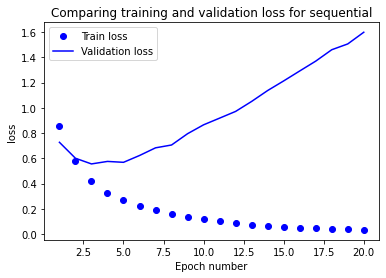

In [19]:
#Training and visualizing the data metrics
base_history = deep_model(base_model, X_train_rest, y_train_rest, X_valid, y_valid)
base_min = optimal_epoch(base_history)
eval_metric(base_model, base_history, 'loss')

**Addressing Overfitting**

Minimum validation loss reached in epoch 13


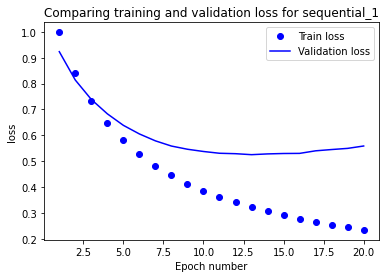

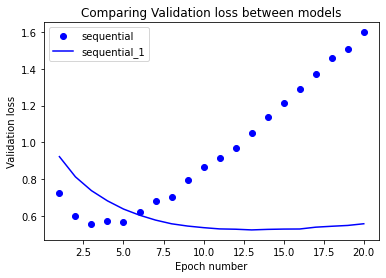

In [20]:
#Redefining architecture to lower network capacity and visualizing it
reduced_model = models.Sequential()
reduced_model.add(layers.Dense(16, activation='relu', input_shape=(NB_WORDS,)))
reduced_model.add(layers.Dense(3, activation='softmax'))
reduced_history = deep_model(reduced_model, X_train_rest, y_train_rest, X_valid, y_valid)
reduced_min = optimal_epoch(reduced_history)
eval_metric(reduced_model, reduced_history, 'loss')

compare_models_by_metric(base_model, reduced_model, base_history, reduced_history, 'val_loss')


Minimum validation loss reached in epoch 4


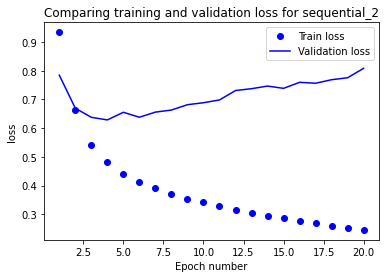

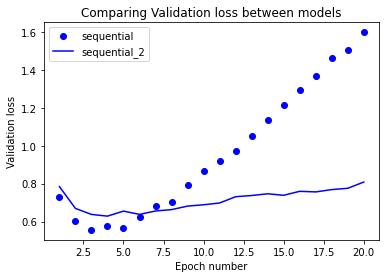

In [21]:
#Redefining architecture again by adding L2 regularization and visualzing it
reg_model = models.Sequential()
reg_model.add(layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), activation='relu', input_shape=(NB_WORDS,)))
reg_model.add(layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
reg_model.add(layers.Dense(3, activation='softmax'))
reg_history = deep_model(reg_model, X_train_rest, y_train_rest, X_valid, y_valid)
reg_min = optimal_epoch(reg_history)

eval_metric(reg_model, reg_history, 'loss')
compare_models_by_metric(base_model, reg_model, base_history, reg_history, 'val_loss')



Minimum validation loss reached in epoch 7


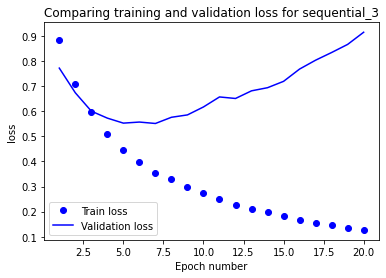

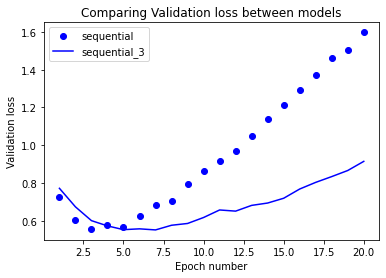

In [22]:
#Redefining model architecture yet again by adding Dropout and visualizing it
drop_model = models.Sequential()
drop_model.add(layers.Dense(64, activation='relu', input_shape=(NB_WORDS,)))
drop_model.add(layers.Dropout(0.5))
drop_model.add(layers.Dense(64, activation='relu'))
drop_model.add(layers.Dropout(0.5))
drop_model.add(layers.Dense(3, activation='softmax'))
drop_history = deep_model(drop_model, X_train_rest, y_train_rest, X_valid, y_valid)
drop_min = optimal_epoch(drop_history)

eval_metric(drop_model, drop_history, 'loss')
compare_models_by_metric(base_model, drop_model, base_history, drop_history, 'val_loss')

**Data Evaluation for Different Models**

In [23]:
#Results displayed in the following order: Baseline Model, Reduced Model, Model with L2 Regularization, and Model with Dropout Layers
base_results = test_model(base_model, X_train_oh, y_train_oh, X_test_oh, y_test_oh, base_min)
reduced_results = test_model(reduced_model, X_train_oh, y_train_oh, X_test_oh, y_test_oh, reduced_min)
reg_results = test_model(reg_model, X_train_oh, y_train_oh, X_test_oh, y_test_oh, reg_min)
drop_results = test_model(drop_model, X_train_oh, y_train_oh, X_test_oh, y_test_oh, drop_min)

46/46 [==============================] - 0s 3ms/step - loss: 1.1381 - accuracy: 0.7561

Test accuracy: 75.61%
46/46 [==============================] - 0s 3ms/step - loss: 0.6356 - accuracy: 0.7828

Test accuracy: 78.28%
46/46 [==============================] - 0s 3ms/step - loss: 0.7381 - accuracy: 0.7944

Test accuracy: 79.44%
46/46 [==============================] - 0s 3ms/step - loss: 0.9026 - accuracy: 0.7842

Test accuracy: 78.42%
